# Analysis of ATM activities in Argentina

### About the data set

This dataset provides information about activities on ATM over the country of Argentina.
The dataset contains the following info:
    - ATM Address,
    - Activity Description (withdraw, deposit, payment ...),
    - Date,
    - Value

### Libraries importing

In [57]:
import pyspark.sql.functions as func
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
#!pip install <library>

### Credentials for accessing files in Object Storage

In [59]:
# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_aa816606(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '37ef207335594d13ab057421343b750e')
    hconf.set(prefix + '.username', '764d9f481c0e462ebb661d83eaed0397')
    hconf.set(prefix + '.password', 'EQTbS)(&cj=Ld763')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_aa816606(name)

spark = SparkSession.builder.getOrCreate()

### Loading the main dataset

In [60]:
df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://BCPPER.' + name + '/ATM_ACTIVITIES_JAN_FEB_16_6.csv')\
  .select('direccion','localidad','provincia','descr','ta_fecha','ta_hora','ta_valor')\
  .cache()

In [61]:
df_data_1.show(5)

+--------------------+------------+----------+-------------+----------+--------------------+--------+
|           direccion|   localidad| provincia|        descr|  ta_fecha|             ta_hora|ta_valor|
+--------------------+------------+----------+-------------+----------+--------------------+--------+
| juan josé paso 5753|     rosario|  santa fé|   extraccion|2016-02-05|2016-02-05 08:17:...| 1500.00|
|av. pte. nestor c...|río gallegos|santa cruz|transferencia|2016-02-01|2016-01-30 20:15:...| 5000.00|
|av. pte. nestor c...|río gallegos|santa cruz|transferencia|2016-01-07|2016-01-07 16:38:...| 3100.00|
|    av. argentina 41|     neuquén|   neuquén|transferencia|2016-02-01|2016-02-01 15:27:...|  933.48|
|          fleming 46|      roldan|  santa fé|   extraccion|2016-01-07|2016-01-07 20:20:...| 1000.00|
+--------------------+------------+----------+-------------+----------+--------------------+--------+
only showing top 5 rows



### Adding dataset with geographic location for addresses in Argentina

In [62]:
df_data_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://BCPPER.' + name + '/GEO_LOC_CITIES.csv').cache()

In [63]:
df_data_2.show(5)

+-----------+----------+----------+
|  localidad|       lat|       lon|
+-----------+----------+----------+
|rio segundo|-31.650785|-63.905846|
| loma negra|-34.209690|-60.728348|
|san vicente|-26.995216|-54.485780|
|   san juan|-31.535107|-68.538600|
|   macachin|-37.137123|-63.667070|
+-----------+----------+----------+
only showing top 5 rows



### Checking which activity is used the most

In [64]:
df_data_4 = df_data_1.groupBy('descr').count().orderBy('count',ascending=False).limit(4).toPandas()

In [65]:
df_data_4

,descr,count
0,extraccion,554707
1,transferencia,443242
2,deposito,54694
3,pago de servicio,29038


### Bar chart with matplotlib

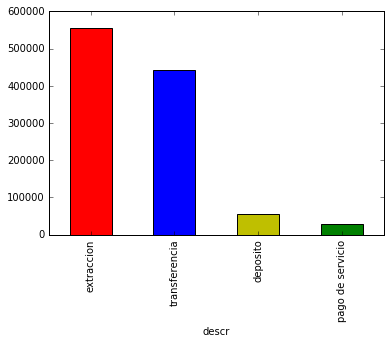

In [66]:
df_data_4.plot(x='descr', y='count', kind='bar', color=['r','b','y','g']).legend_.remove()

### Visualization with Pixiedust


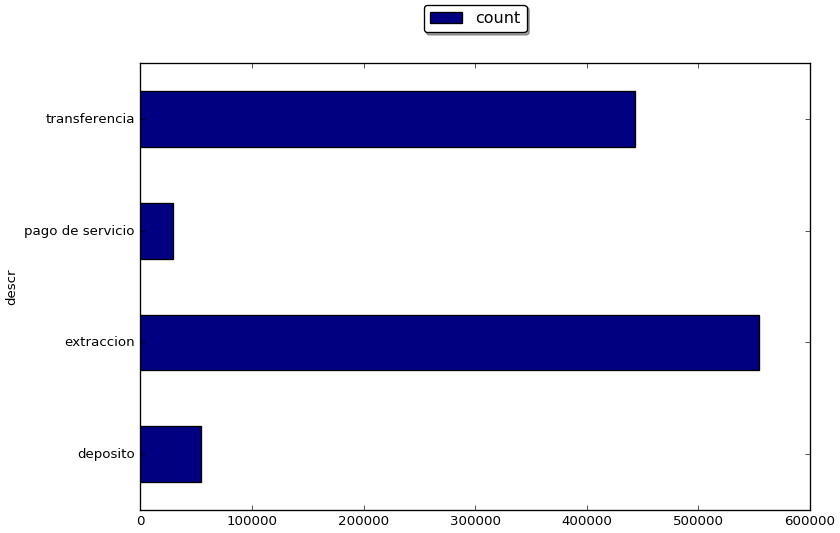

In [ ]:
import pixiedust
display(df_data_4)

### Checking where ATM activities are concentrating the most

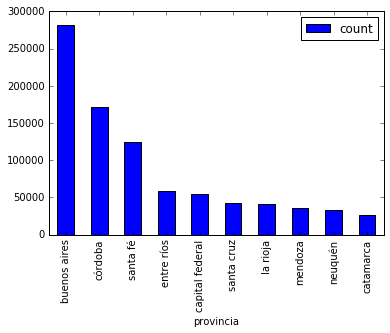

In [68]:
df_data_1.groupBy('provincia').count().orderBy('count',ascending=False).limit(10).toPandas().plot(x='provincia', y='count', kind='bar')

### Heat map

In [69]:
df_data_3 = df_data_1.groupBy(df_data_1.localidad).count().join(df_data_2, df_data_1.localidad == df_data_2.localidad)\
.select(df_data_1.localidad,'count','lat','lon').orderBy('count').limit(100).toPandas()

In [70]:
lats = [float(item) for item in df_data_3.lat]
lons = [float(item) for item in df_data_3.lon]
mag = [float(item) for item in df_data_3['count']]

In [71]:
import folium
from folium import plugins

schools_heatmap = folium.Map(location=[-34.418876, -60.042412], zoom_start=6)
schools_heatmap.add_child(plugins.HeatMap(zip(lats, lons, mag), radius = 16))
schools_heatmap